<a href="https://colab.research.google.com/github/kumiori/mec647/blob/Assala_T/mec647_Fracture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh


In [2]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML



# Testing

Features and branches, all in all.

In [3]:
branch_name = 'main'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git


Cloning into 'mec647'...
remote: Enumerating objects: 652, done.
remote: Counting objects: 100% (652/652), done.
remote: Compressing objects: 100% (535/535), done.
remote: Total 652 (delta 287), reused 283 (delta 98), pack-reused 0
Receiving objects: 100% (652/652), 12.60 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (287/287), done.


In [4]:
import mec647

In [5]:
sys.path.append('mec647/')


In [6]:
import matplotlib.pyplot as plt
from petsc4py import PETSc

from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

# meshes
import meshes
from meshes import primitives

In [7]:
# Parameters

parameters = {
    'loading': {
        'min': 0,
        'max': 1.3,
        'steps': 10
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.1
    },
    'model': {
        'E': 1.,
        'nu': 0.,
        'w1': 1.,
        'ell': 0.05,
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            },
        },
                'damage_elasticity': {
                "max_it": 100,
                "alpha_rtol": 1.0e-5,
                "criterion": "alpha_H1"
            }
    }
}

In [8]:
parameters.get("solvers")

{'damage': {'snes': {'ksp_type': 'preonly',
   'pc_factor_mat_solver_type': 'mumps',
   'pc_type': 'lu',
   'snes_atol': 1e-05,
   'snes_max_it': 100,
   'snes_monitor': '',
   'snes_rtol': 1e-08,
   'snes_stol': 1e-05,
   'snes_type': 'vinewtonrsls'}},
 'damage_elasticity': {'alpha_rtol': 1e-05,
  'criterion': 'alpha_H1',
  'max_it': 100},
 'elasticity': {'snes': {'ksp_type': 'preonly',
   'pc_factor_mat_solver_type': 'mumps',
   'pc_type': 'lu',
   'snes_atol': 1e-08,
   'snes_max_it': 100,
   'snes_monitor': '',
   'snes_rtol': 1e-08,
   'snes_stol': 1e-08,
   'snes_type': 'newtontr'}}}

In [9]:
parameters.get("model").get("ell")

0.05

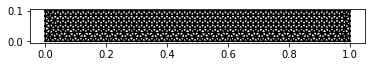

In [10]:
# Mesh

Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]

gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    parameters.get("model").get("ell")/3, 
                                    tdim=2)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)


from utils.viz import plot_mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")


In [11]:
# Functional Setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)

element_alpha = ufl.FiniteElement("Lagrange", mesh.ufl_cell(),
                              degree=1)

V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_ = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")


alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")

dx = ufl.Measure("dx", domain = mesh)
ds = ufl.Measure("ds", domain = mesh)

In [13]:
import numpy as np


In [14]:
# Boundary sets

dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], 0.))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))

dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))

In [ ]:
np.ones_like([1, 2, 3, 4])

array([1, 1, 1, 1])

In [15]:
# Boundary data

u_.interpolate(lambda x: (np.ones_like(x[0]), np.zeros_like(x[1])))

In [16]:
u_.vector[:]

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

In [17]:
# Boundary conditions

bcs_u = [
         dirichletbc(np.array([0., 0.], dtype=PETSc.ScalarType),
                      dofs_u_left,
                      V_u),
         dirichletbc(u_, dofs_u_right)
         ]

bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_left, dofs_alpha_right]),
                         V_alpha)
]


In [18]:
import models
from models import DamageElasticityModel as Brittle

In [19]:
bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}
state = {"u": u, "alpha": alpha}

model = Brittle(parameters["model"])


total_energy = model.total_energy_density(state) * dx

In [20]:
import algorithms
from algorithms import am

In [21]:
solver = am.AlternateMinimisation(total_energy,
                         state,
                         bcs,
                         parameters.get("solvers"),
                         bounds=(alpha_lb, alpha_ub)
                         )

In [23]:
from mpi4py import MPI

In [26]:

import ufl
import dolfinx
from petsc4py import PETSc
import sys
import petsc4py

In [28]:
import numpy
import sys
from mpi4py import MPI
from mpi4py.MPI import ANY_SOURCE

In [30]:
comm = MPI.COMM_WORLD

In [31]:
# Loop for evolution


loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

for (i_t, t) in enumerate(loads):
  # update boundary conditions

  u_.interpolate(lambda x: (t * np.ones_like(x[0]), np.zeros_like(x[1])))
  u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # update lower bound for damage
  alpha.vector.copy(alpha_lb.vector)
  alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # solve for current load step
  print(f"Solving timestep {i_t}, load: {t}")

  solver.solve()

  # postprocessing
  # global

  surface_energy = comm.allreduce(
          assemble_scalar(
            dolfinx.fem.form(model.damage_dissipation_density(state) * dx)),
          op=MPI.SUM
          )

  elastic_energy = comm.allreduce(
      assemble_scalar(
        dolfinx.fem.form(model.elastic_energy_density(state) * dx)),
          op=MPI.SUM
        )
  print(f"Solved timestep {i_t}, load: {t}")
  print(f"Elastic Energy {elastic_energy:.3g}, Surface energy: {surface_energy:.3g}")
  print("\n\n")

  # savings








Solving timestep 0, load: 0.0
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 0, load: 0.0
Elastic Energy 0, Surface energy: 0



Solving timestep 1, load: 0.14444444444444446
  0 SNES Function norm 5.619778090531e-01 
  1 SNES Function norm 5.013938546389e-01 
  2 SNES Function norm 3.802259458104e-01 
  3 SNES Function norm 1.378901281533e-01 
  4 SNES Function norm 3.294487456912e-16 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 1, load: 0.14444444444444446
Elastic Energy 0.00104, Surface energy: 0



Solving timestep 2, load: 0.2888888888888889
  0 SNES Function norm 5.619778090531e-01 
  1 SNES Function norm 4.495822472425e-01 
  2 SNES Function norm 2.247911236213e-01 
  3 SNES Function norm 5.833247285402e-16 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 2, load: 0.2888888888888889
Elastic Energy 0.00417, Surface energy: 0



Solving timestep 3, load: 0.43333333333333335
  0 SNES Function norm 5.61

In [40]:
import dolfinx.plot
from dolfinx.plot import create_vtk_topology
from IPython.display import Image, display
import pyvista
from pyvista.utilities import xvfb
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

plotter = pyvista.Plotter()

grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
grid.point_data["alpha"] = alpha.compute_point_values().real
grid.set_active_scalars("alpha")

plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    figure = plotter.screenshot("bar_f.png")

ImportError: ignored

In [34]:
import pyvista
from pyvista.utilities import xvfb

import dolfinx.plot

from mec647.utils.viz import plot_vector, plot_scalar, plot_profile

xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True

plotter = pyvista.Plotter(
    title="Test VI",
    window_size=[800, 600],
    shape=(1, 1),
)
_props = {"show_edges":True, "show_scalar_bar": True, "clim":[0, 1]}
_plt,data = plot_scalar(alpha, plotter, subplot=(0, 0), lineproperties=_props)

# _plt = plot_vector(u, plotter, subplot=(0, 1))

_plt.screenshot(f"./output/test_vi_MPI{MPI.COMM_WORLD.size}.png")



ValueError: ignored